In [1]:
import pickle
import warnings
import random
import torch

import numpy as np
import pandas as pd

from tqdm import tqdm
from glob import glob
from collections import OrderedDict
from scipy.spatial import distance
from scipy import stats
from sklearn import decomposition

from torch.nn import functional as F

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

%matplotlib inline

In [3]:
warnings.simplefilter('ignore')
alt.data_transformers.enable('default', max_rows=None)
pd.options.display.max_rows = 200

In [4]:
embeds, rows = [], []

for path in tqdm(glob('../data/b13-embeds/*.p')):
    with open(path, 'rb') as fh:
        
        lines = pickle.load(fh)

        for line in lines:
            title = ' '.join(line.pop('tokens'))
            embeds.append(line.pop('embedding'))
            rows.append(OrderedDict(title=title, **line))

100%|██████████| 99/99 [00:35<00:00,  2.83it/s]


In [5]:
embeds = np.stack(embeds)

In [6]:
df = pd.DataFrame(rows)

In [7]:
df.label.unique()

array(['dailycaller.com', 'thehill.com', 'bloomberg.com', 'breitbart.com',
       'buzzfeed.com', 'cnn.com', 'nytimes.com', 'apnews.com',
       'huffingtonpost.com', 'washingtonpost.com', 'wsj.com',
       'foxnews.com', 'dailykos.com'], dtype=object)

In [8]:
embeds.shape

(982833, 512)

In [35]:
center = embeds.mean(0)

In [48]:
def ds_from_center(domain, metric):
    
    ds = []
    for v in embeds[df[df.label==domain].index]:
        ds.append(metric(center, v))
        
    return ds

In [49]:
domains = df.label.unique()

In [64]:
def plot_step_hist(ds):
    
    plt.figure(figsize=(15,10))

    ys, x, _ = plt.hist(
        ds.values(),
        label=ds.keys(),
        histtype='step',
        bins=100,
        linewidth=2,
    )

    plt.legend(loc='upper right')
    
    return x, ys

In [66]:
def plot_step_hist_interactive(x, ys):

    rows = []
    for y, domain in zip(ys, ds.keys()):
        for d, count in zip(x[:-1], y):
            rows.append((domain, d, count))

    hist_df = pd.DataFrame(rows, columns=('domain', 'd', 'count'))
    
    highlight = alt.selection(
        type='single',
        on='mouseover',
        fields=['domain'],
        nearest=True,
    )

    base = (alt
        .Chart(hist_df, width=700, height=500)
        .encode(x=alt.X('d', scale=alt.Scale(zero=False)), y='count', color='domain'))

    points = (base
        .mark_circle()
        .encode(opacity=alt.value(0))
        .add_selection(highlight)
        .properties(width=600))

    lines = (base
        .mark_line()
        .encode(size=alt.condition(~highlight, alt.value(2), alt.value(5)), tooltip='domain'))

    return points + lines

In [68]:
def plot_ds_violin(ds):

    rows = []
    for domain, dds in ds.items():
        for d in dds:
            rows.append((domain, d))
            
    ds_df = pd.DataFrame(rows, columns=('domain', 'd'))
    
    order = ds_df.groupby('domain').mean().sort_values('d', ascending=False).index
    plt.figure(figsize=(5,10))
    sns.violinplot(y='domain', x='d', data=ds_df.sample(frac=0.01), order=order)

In [76]:
ds = {
    d: ds_from_center(d, distance.cosine)
    for d in tqdm(domains)
}

100%|██████████| 13/13 [00:54<00:00,  4.20s/it]


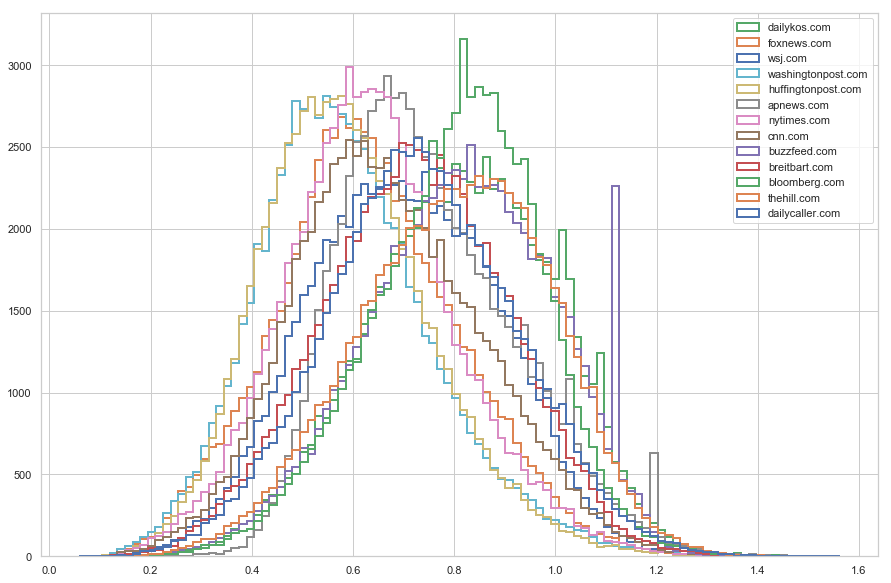

In [77]:
x, ys = plot_step_hist(ds)

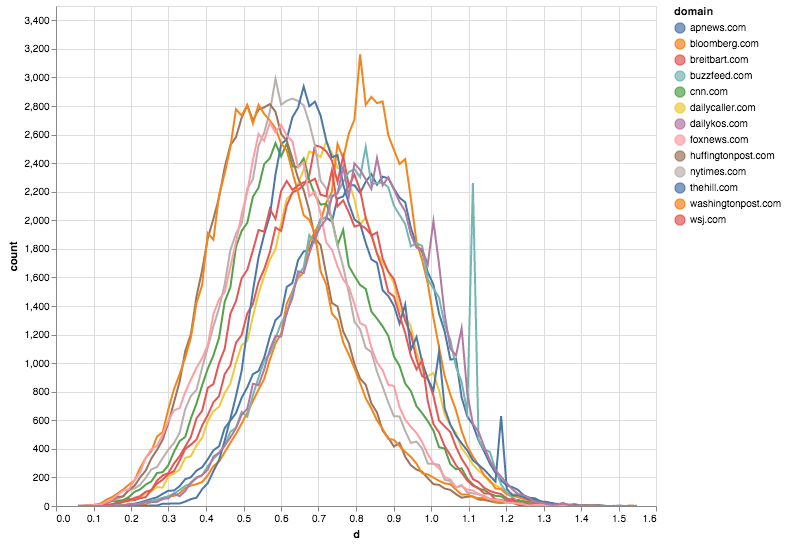

In [67]:
plot_step_hist_interactive(x, ys)

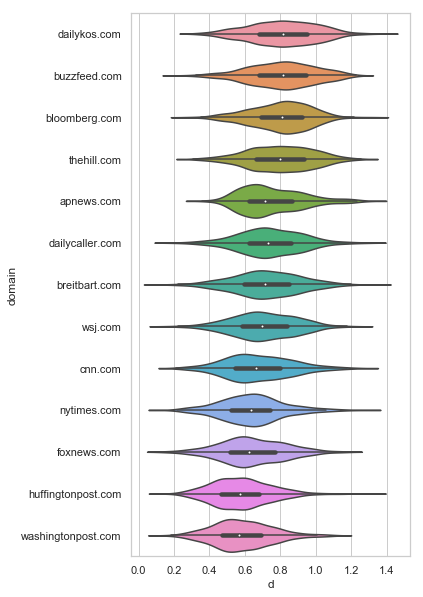

In [69]:
plot_ds_violin(ds)

In [70]:
ds = {
    d: ds_from_center(d, distance.euclidean)
    for d in tqdm(domains)
}

100%|██████████| 13/13 [00:19<00:00,  1.46s/it]


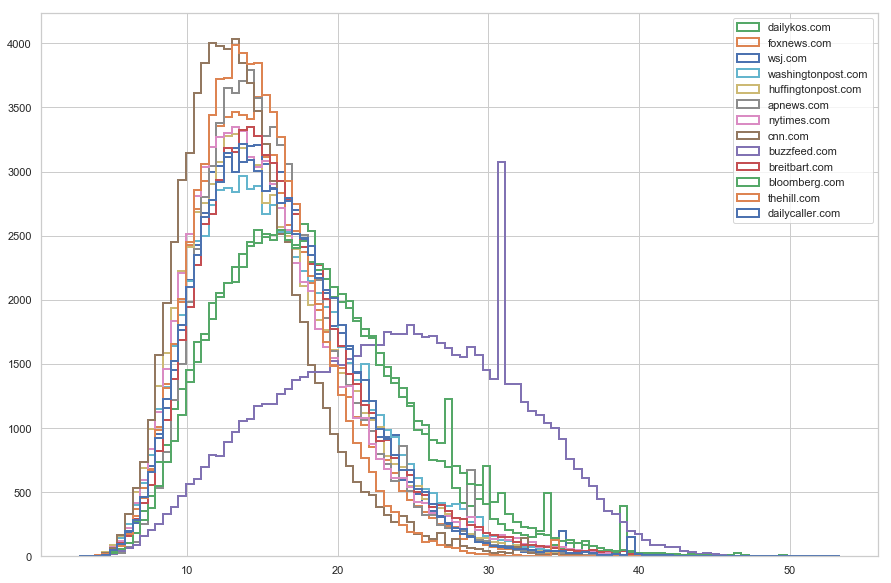

In [71]:
x, ys = plot_step_hist(ds)

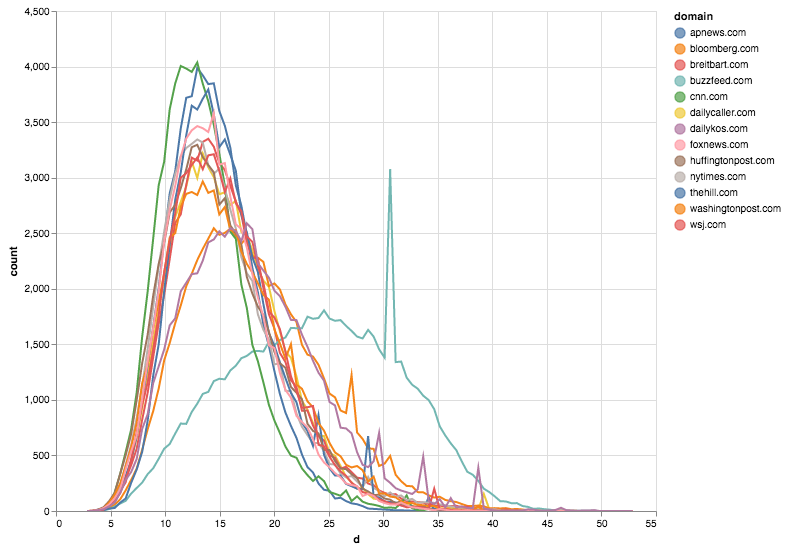

In [72]:
plot_step_hist_interactive(x, ys)

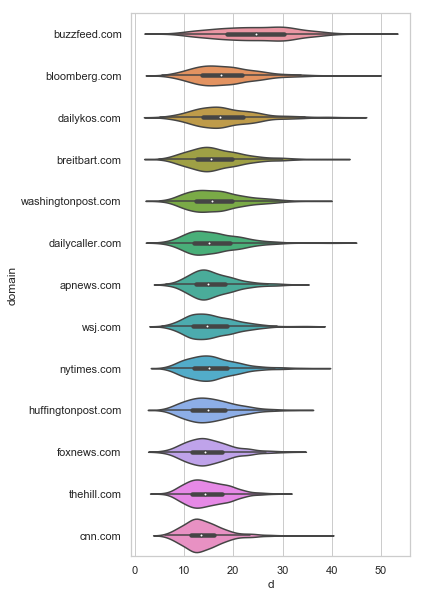

In [73]:
plot_ds_violin(ds)